# Zuppa R-CNN Stage 1



In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
from imgaug import augmenters as iaa

# Root directory of the project
# ROOT_DIR = os.path.abspath("C:/mask/Mask_RCNN/")
MASK_RCNN_ROOT_DIR = "../Mask_RCNN/"
COCO_ROOT_DIR = "."

# Import Mask RCNN
sys.path.append(MASK_RCNN_ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(COCO_ROOT_DIR, "samples/zuppa/"))  # To find local version
import zuppa as coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(COCO_ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "mask_rcnn_zuppa_0091.h5")
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0043.h5") #lowest validation loss
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0100.h5") #max epoch before augmentation
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0127.h5") #epoch with augmentation (teh best one)
COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0149.h5") #before extreme augmentation & training all data
# COCO_MODEL_PATH = os.path.join(COCO_ROOT_DIR, "logs/zuppa20190305T1602/mask_rcnn_zuppa_0174.h5") #extreme augmentation & train all data #likely overfit
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/train") #test back on images used for training
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/val") #test on images used for validation (proper)
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images2") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images3") #other directory for testing


Using TensorFlow backend.


In [2]:
# Check if GPU used (prints in console/terminal)

import tensorflow as tf;
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

False

In [3]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12921871560417637382
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10352275707564805442
physical_device_desc: "device: XLA_CPU device"
]


In [4]:
class InferenceConfig(coco.BalloonConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.7
    DETECTION_MAX_INSTANCES=10

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Create Model and Load Trained Weights

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 149


In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'Sour', 'Tiger', 'Flower', 'Lychee', 'Milo']

## Run Object Detection

1 / 1
2019-03-26_151103_155.jpg


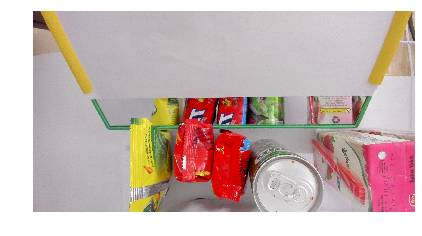

width 1651
height 870


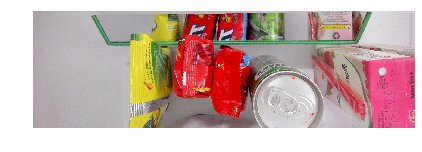

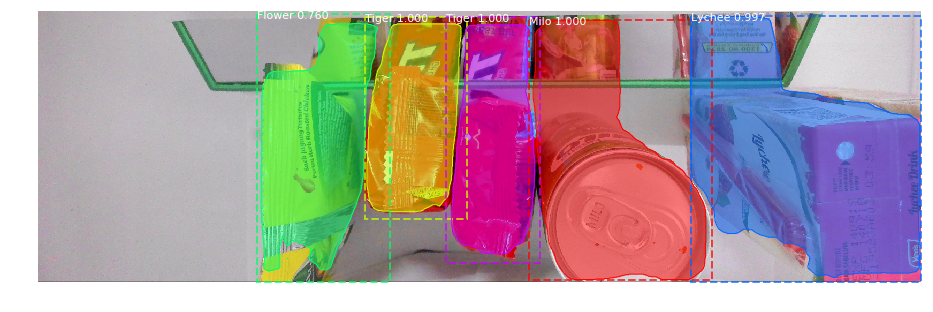

[('Flower', 1), ('Lychee', 1), ('Milo', 1), ('Tiger', 2)]


In [10]:


# Directory of images to run detection on
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/train") #test back on images used for training
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "samples/zuppa/dataset/val") #test on images used for validation (proper)
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images") #other directory for testing
# IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images2") #other directory for testing
IMAGE_DIR = os.path.join(COCO_ROOT_DIR, "images3") #other directory for testing


IMAGE_CROP = False
IMAGE_CROP = True

# Load a random image from the images folder

file_names = next(os.walk(IMAGE_DIR))[2] #all
file_names = list(filter(lambda x: x.endswith('.jpg'), file_names))

# file_names = [random.choice(file_names)] #random one
file_names = [file_names[-1]] #last one


# print(file_names)
    
def class_id_to_class_name(class_id):
    return class_names[class_id]

    
    
TEST_AUGMENTATION=True
TEST_AUGMENTATION=False
    
if(TEST_AUGMENTATION):
    augmentation = iaa.Sequential([
        # iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5),  # horizontally flip 50% of the images
    #     iaa.Dropout([0.05, 0.1]),
        # blur images with a sigma of 0 to 3.0
        iaa.Sometimes(0.5, iaa.Affine(scale=(0.9, 1.1))),
        iaa.Sometimes(0.5, iaa.Affine(shear=(-16, 16))),
    #     iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.Sometimes(0.5, iaa.ContrastNormalization((0.7, 1.3))),
        iaa.Sometimes(0.5, iaa.PiecewiseAffine(scale=(0.00, 0.015))),
        iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha=(0, 5.0), sigma=0.25))
    ])



def detect(image):
# Run detection
    SHOW_VERBOSE = False
#     SHOW_VERBOSE = True
    results = model.detect([image], verbose=SHOW_VERBOSE)

#     print(len(results))

    # Visualize results
    r = results[0] #so far there's only 1 result

    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                class_names, r['scores'])


    detected_class_names = list(map(class_id_to_class_name, r['class_ids']))
#     print(detected_class_names)
#     print(list(zip(r['class_ids'], r['scores'])))
#     print(list(zip(detected_class_names, r['scores'])))

    # ref https://stackoverflow.com/a/2162045/3553367
    counter=collections.Counter(detected_class_names)
    # ref: https://stackoverflow.com/a/17930886/3553367
    print(sorted(counter.items()))
    
    
for index, file_name in enumerate(file_names):
    print(index + 1, '/' ,len(file_names))
    print(file_name)
    image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))
    skimage.io.imshow(image)
    plt.axis('off')
    plt.show()

    if(IMAGE_CROP):
        width = image.shape[1]
        height = image.shape[0]
        print('width', width)
        print('height', height)

        x1 = 0
        x2 = width-1
        y1 = int((height-1)*0.42) #cut of 30% of from top
#         y1 = int((height-1)*0.5) #cut of 30% of from top
        y2 = height
        image_crop = image[y1:y2, x1:x2]
        skimage.io.imshow(image_crop)
        plt.axis('off')
        plt.show()
        
        image = image_crop

    
    if(TEST_AUGMENTATION):
        image_aug = augmentation.augment_image(image)
        skimage.io.imshow(image_aug)
        plt.axis('off')
        plt.show()
    
    RUN_DETECTION=True    
#     RUN_DETECTION=False
    
    if(RUN_DETECTION):
        detect(image)
        if(TEST_AUGMENTATION):
            detect(image_aug)